# Download the data
http://archive.ics.uci.edu/ml/machine-learning-databases/eeg-mld/

In [44]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/eeg-mld/eeg_full.tar    

--2018-11-02 13:25:24--  http://archive.ics.uci.edu/ml/machine-learning-databases/eeg-mld/eeg_full.tar
Risoluzione di archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connessione a archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:80... connesso.
Richiesta HTTP inviata, in attesa di risposta... 200 OK
Lunghezza: 717894656 (685M) [application/x-tar]
Salvataggio in: "eeg_full.tar"

eeg_full.tar        100%[===================>] 684,64M  16,5MB/s    in 47s     s

2018-11-02 13:26:12 (14,5 MB/s) - "eeg_full.tar" salvato [717894656/717894656]



In [2]:
!mkdir full
!tar xf eeg_full.tar  -C full

## Imports

In [2]:
import xarray as xr
import numpy as np
import glob, tarfile, gzip, io, os
import pandas as pd

In [4]:
import matplotlib.pyplot as plt
#import hvplot.xarray

## Extract the datasets in two paths: one for control and the other for alcoholic

#### Create a dict to hold the names

In [6]:
datasets_full = glob.glob('full/*.tar.gz')
datasets = [{'tar':[f for f in datasets_full if f[8]=='c'], 'name':"control"},
            {'tar':[f for f in datasets_full if f[8]=='a'], 'name':"alcoholic"}]

In [7]:
for dat in datasets:
    for f in dat['tar']:
        if not os.path.exists(dat['name']): 
            os.mkdir(dat['name'])
        tar = tarfile.open(f)
        tar.extractall(path=dat['name'])
        tar.close()
    # build a list with file names to use later
    gz_dirs = glob.glob(dat['name']+os.path.sep+'*'+ os.path.sep)
    subjs = dat.get('subjs', {})
    for gz_dir in gz_dirs:
        subj = gz_dir.split('/')[1]
        subj_ = subjs.get(subj, {})
        subj_['files'] = glob.glob(gz_dir+'/*.gz')
        subjs[subj] = subj_
    dat['subjs'] = subjs

## Explore the data for one subject

### read the data for one subject and put it in a list

In [47]:
#%%snip_add python gzip "Reading Compressed Data"

a_444_set = glob.glob('alcoholic/co2a0000444/*')
data = []
for file in a_444_set:
    with gzip.open(file, 'rb') as file_handle:
        with io.TextIOWrapper(file_handle, encoding='utf-8') as dec: 
            for i, line in enumerate(dec.readlines()):
                if line[0] == '#':
                    # Line 4 identifies the matching conditions for the image: 
                    # (S1 obj), a single object shown  
                    # (S2 match), object 2 shown in a matching condition  
                    # (S2 nomatch). object 2 shown in a non matching condition  
                    if i == 3: 
                        #print(line)
                        match_cond , trial_num = line.split(',')
                        match_cond = match_cond[2:].strip()
                        trial_num = int(trial_num.split()[1])
                else:                     
                    data.append([match_cond]+line.split())
                #  trial number, sensor position, sample number (0-255), and sensor value (in micro volts).                    


### Create the pandas DataFrame from 2-d data

In [48]:
df = pd.DataFrame(data = data, columns=['match_cond', 'trial_num', 'sensor', 'sample', 'value'])
#df = df.drop('sample', axis=1)
#df.set_index(['match_cond', 'trial_num', 'sensor'], inplace=True)
df.set_index(['match_cond', 'trial_num', 'sensor', 'sample'], inplace=True)
#df.set_index(['sample'], inplace=True)

In [49]:
df

value
match_cond trial_num sensor sample         
S1 obj     74        FP1    0        -2.604
                            1        -2.604
                            2        -3.092
                            3        -5.046
                            4        -8.464
                            5       -11.882
                            6       -14.811
                            7       -16.764
                            8       -18.229
                            9       -18.717
                            10      -18.717
                            11      -18.229
                            12      -16.764
                            13      -15.299
                            14      -13.346
                            15      -11.393
                            16       -9.928
                            17       -7.975
                            18       -5.046
                            19       -2.604
                            20        0.326
                            21        2.279
                            22        2.767
                            23        1.790
                            24       -0.651
                            25       -2.604
                            26       -4.557
                            27       -6.022
                            28       -7.487
                            29       -8.952
...                                     ...
           110       Y      226     -29.978
                            227     -28.514
                            228     -26.072
                            229     -25.096
                            230     -25.096
                            231     -23.142
                            232     -15.818
                            233      -3.611
                            234       7.131
                            235       8.596
                            236      -1.658
                            237     -19.725
                            238     -34.861
                            239     -39.256
                            240     -31.932
                            241     -17.771
                            242      -3.123
                            243       7.131
                            244      10.061
                            245       5.178
                            246      -4.100
                            247     -14.842
                            248     -19.236
                            249     -14.842
                            250      -4.588
                            251       4.690
                            252       4.690
                            253      -3.611
                            254     -13.865
                            255     -16.795

[1310720 rows x 1 columns]

### convert the pandas DataFrame to xarray DataSet

In [50]:
# ds = xr.Dataset(df)
ds = df.to_xarray()
ds
#ds.rename()

<xarray.Dataset>
Dimensions:     (match_cond: 3, sample: 256, sensor: 64, trial_num: 80)
Coordinates:
  * match_cond  (match_cond) object 'S1 obj' 'S2 match' 'S2 nomatch'
  * trial_num   (trial_num) object '10' '100' '101' '102' ... '96' '97' '99'
  * sensor      (sensor) object 'AF1' 'AF2' 'AF7' 'AF8' ... 'TP8' 'X' 'Y' 'nd'
  * sample      (sample) object '0' '1' '10' '100' '101' ... '96' '97' '98' '99'
Data variables:
    value       (match_cond, trial_num, sensor, sample) object '0.203' ... nan

### Convert to native types

In [51]:
ds['val'] = ds.value.astype(np.float)
ds['sample'] = ds.sample.astype(np.int)
ds['trial_num'] = ds.trial_num.astype(np.int)
ds = ds.drop('value')
ds

<xarray.Dataset>
Dimensions:     (match_cond: 3, sample: 256, sensor: 64, trial_num: 80)
Coordinates:
  * match_cond  (match_cond) object 'S1 obj' 'S2 match' 'S2 nomatch'
  * trial_num   (trial_num) int64 10 100 101 102 103 104 ... 87 93 94 96 97 99
  * sensor      (sensor) object 'AF1' 'AF2' 'AF7' 'AF8' ... 'TP8' 'X' 'Y' 'nd'
  * sample      (sample) int64 0 1 10 100 101 102 103 ... 93 94 95 96 97 98 99
Data variables:
    val         (match_cond, trial_num, sensor, sample) float64 0.203 ... nan

### Encode the sensor as an int value coordinate and save the original

In [52]:
ds['sensor_'] = ds['sensor']
ds = ds.set_coords('sensor_')
ds['sensor'] = np.arange(len(ds.sensor.values))
ds

<xarray.Dataset>
Dimensions:     (match_cond: 3, sample: 256, sensor: 64, trial_num: 80)
Coordinates:
  * match_cond  (match_cond) object 'S1 obj' 'S2 match' 'S2 nomatch'
  * trial_num   (trial_num) int64 10 100 101 102 103 104 ... 87 93 94 96 97 99
  * sensor      (sensor) int64 0 1 2 3 4 5 6 7 8 ... 55 56 57 58 59 60 61 62 63
  * sample      (sample) int64 0 1 10 100 101 102 103 ... 93 94 95 96 97 98 99
    sensor_     (sensor) object 'AF1' 'AF2' 'AF7' 'AF8' ... 'TP8' 'X' 'Y' 'nd'
Data variables:
    val         (match_cond, trial_num, sensor, sample) float64 0.203 ... nan

### explore the data

In [53]:
a_54 = ds.sel(match_cond='S1 obj', trial_num=54)
a_54 = a_54.sortby("sample")

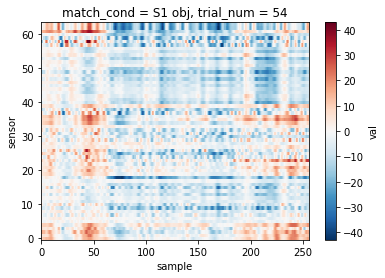

In [54]:
a_54.val.plot()

In [55]:
a_54.sortby("sample").sel(sensor=1).val.hvplot()

:Curve   [sample]   (val)

### organize the data by match_cond, sorted and filtered by the relevant trials

In [56]:
#fig, axes = plt.subplots(ncols=4)
gs = []
for m_cond, group in ds.groupby('match_cond'):
    print(m_cond)
    gs.append( group.dropna(dim='trial_num').sortby(['sample', 'trial_num']) )

S1 obj
S2 match
S2 nomatch


### Plots for one match condition

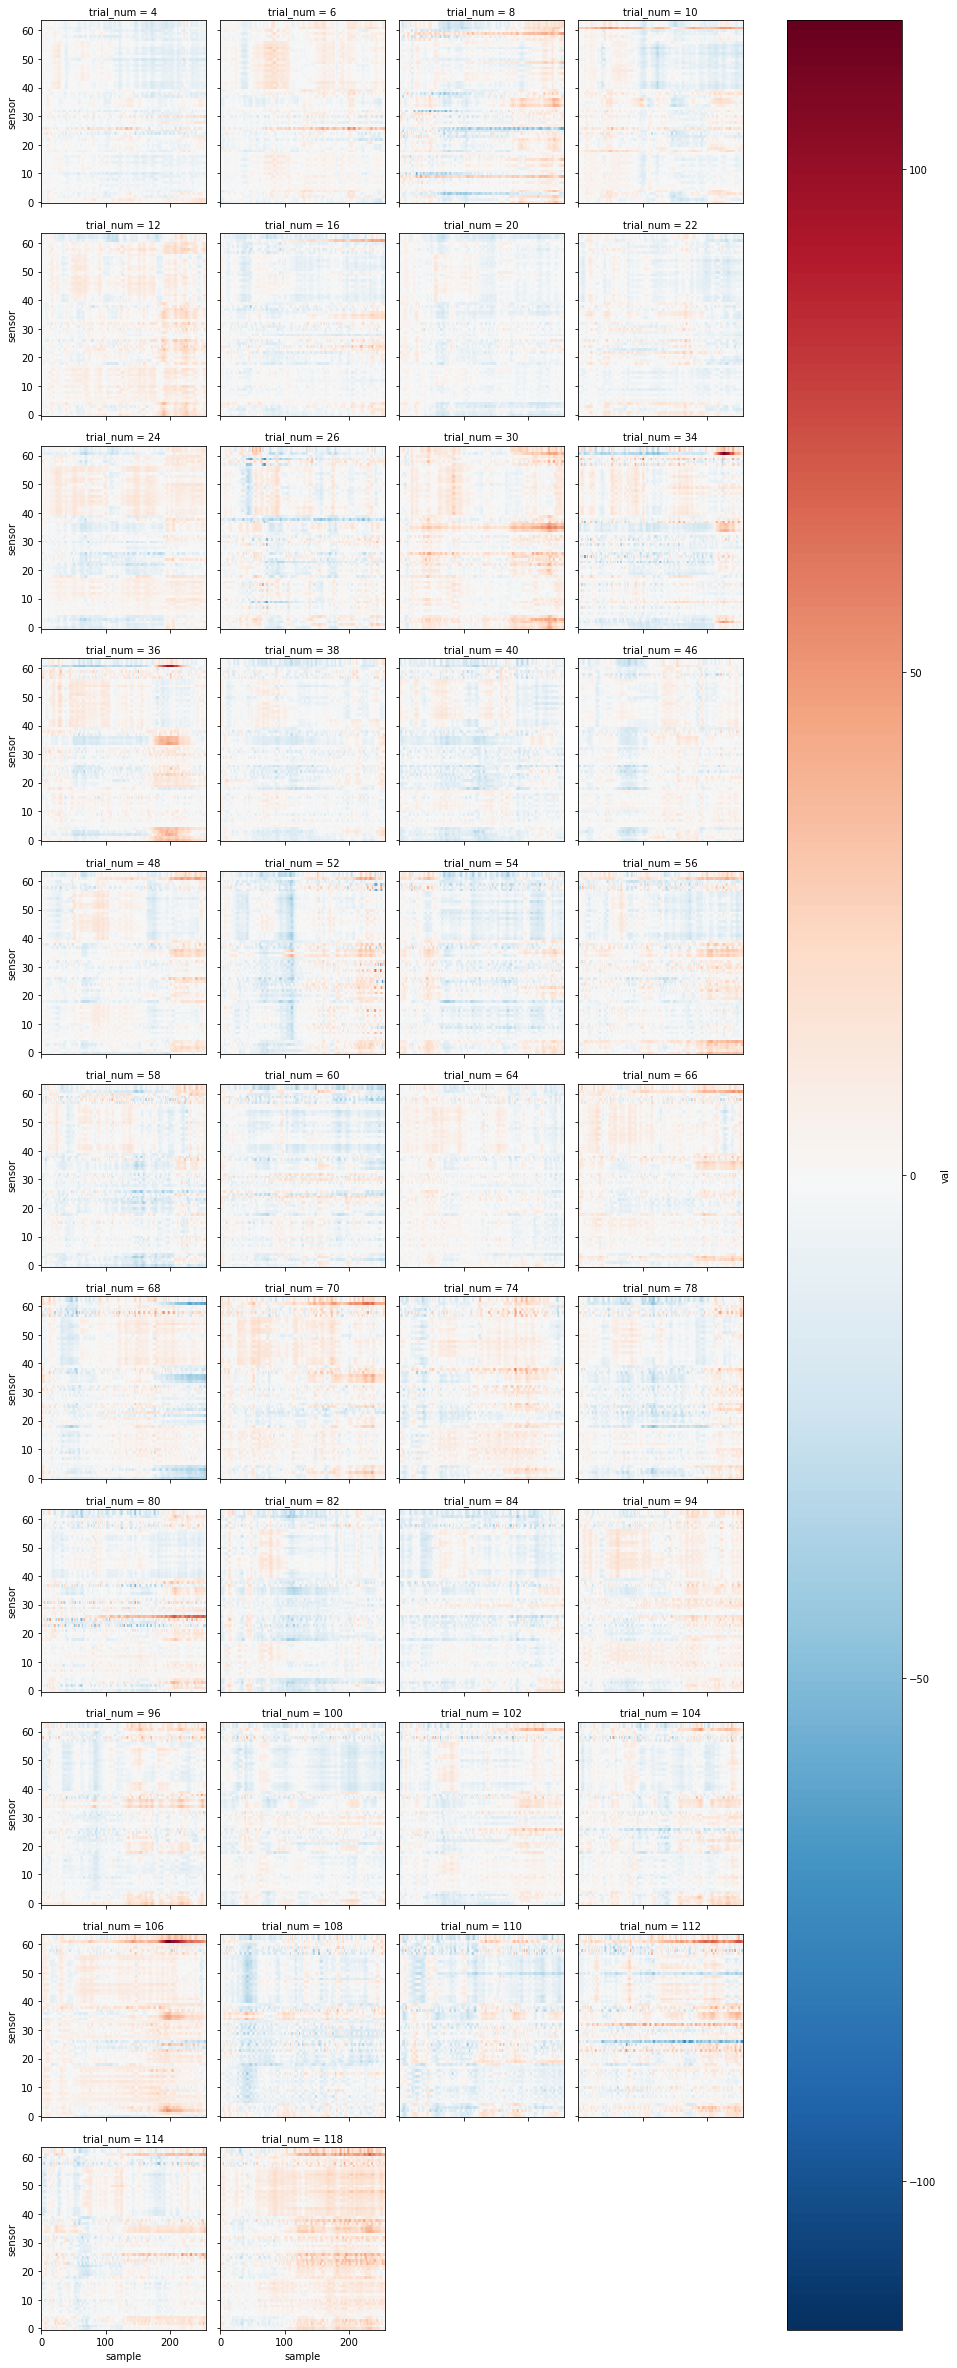

In [57]:
S1_obj = gs[0]
# S1_obj = S1_obj.dropna(dim='trial_num')
S1_obj.val.plot(x='sample', y='sensor', col='trial_num', col_wrap=4) 

In [59]:
S1_obj

<xarray.Dataset>
Dimensions:     (sample: 256, sensor: 64, trial_num: 42)
Coordinates:
    match_cond  <U6 'S1 obj'
  * trial_num   (trial_num) int64 4 6 8 10 12 16 20 ... 106 108 110 112 114 118
  * sensor      (sensor) int64 0 1 2 3 4 5 6 7 8 ... 55 56 57 58 59 60 61 62 63
  * sample      (sample) int64 0 1 2 3 4 5 6 7 ... 249 250 251 252 253 254 255
    sensor_     (sensor) object 'AF1' 'AF2' 'AF7' 'AF8' ... 'TP8' 'X' 'Y' 'nd'
Data variables:
    val         (trial_num, sensor, sample) float64 6.51 6.51 ... -0.081 0.407

### Compute the average off the trials

#### For one match

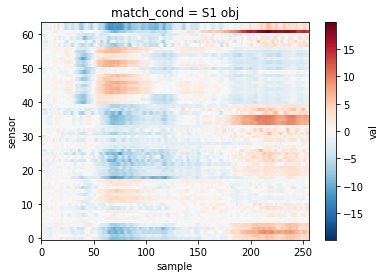

In [60]:
S1_obj.mean("trial_num").val.plot()

#### For all match

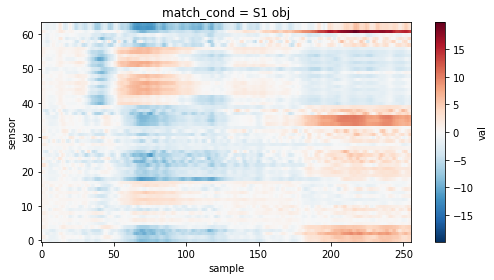

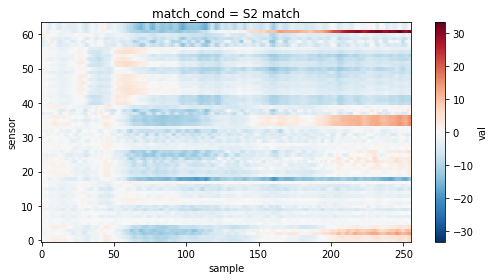

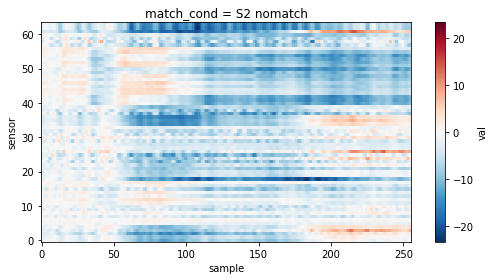

In [61]:
for match in gs:
    match.mean("trial_num").val.plot(aspect=1.8, size=4) 
    plt.tight_layout()

#### That is equivalent to this

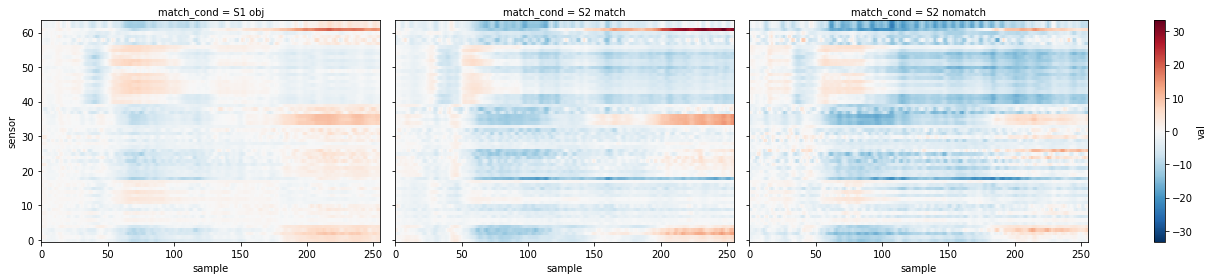

In [62]:
ds.val.mean("trial_num").sortby('sample').plot(x='sample', y='sensor', col='match_cond', col_wrap=3, aspect=1.5, size=4) 

### Create function that compute the same stuff using the code we just tested

In [34]:
def data_from_subject(files=[]):
    data = []
    for file in files:
        with gzip.open(file, 'rb') as file_handle:
            with io.TextIOWrapper(file_handle, encoding='utf-8') as dec: 
                for i, line in enumerate(dec.readlines()):
                    if line[0] == '#':
                        # Line 4 identifies the matching conditions for the image: 
                        # (S1 obj), a single object shown  
                        # (S2 match), object 2 shown in a matching condition  
                        # (S2 nomatch). object 2 shown in a non matching condition  
                        if i == 3: 
                            #print(line)
                            match_cond , trial_num = line.split(',')
                            match_cond = match_cond[2:].strip()
                            trial_num = int(trial_num.split()[1])
                    else:                     
                        data.append([match_cond]+line.split())
                    #  trial number, sensor position, sample number (0-255), and sensor value (in micro volts).                    
    return data

In [35]:
def dataset_from_data(data=[]):
    df = pd.DataFrame(data = data, columns=['match_cond', 'trial_num', 'sensor', 'sample', 'val'])
    df.set_index(['match_cond', 'trial_num', 'sensor', 'sample'], inplace=True)
    ds = df.to_xarray()
    ds['val'] = ds.val.astype(np.float)
    ds['sample'] = ds.sample.astype(np.int)
    ds['trial_num'] = ds.trial_num.astype(np.int)
    ds['sensor_'] = ds['sensor']
    ds = ds.set_coords('sensor_')
    ds['sensor'] = np.arange(len(ds.sensor.values))
    ds = ds.sortby(['trial_num', 'sample']) 
    return ds

## Compute for all subjects

### Extract the data into a single xarray DataSets for each subject and save the result as netcdf file

The saved data will not have a name dimension that make possible to distiguish between different subjects. 

xarray concat have to guess along which dimension to concatenate when considering the datasets as a whole.

In [3]:
def extract_to_xarray():
    for dat in datasets:
        if not os.path.exists(os.path.join('no_name', dat['name'])):
            os.mkdir(os.path.join('no_name', dat['name']))        
        for subj, subj_ in dat['subjs'].items():
            print('='*80); print(subj); print('-'*80)
            data = data_from_subject(subj_['files'])
            ds = dataset_from_data(data)
            fname = os.path.join('no_name', dat['name'], subj + '.nc')
            ds.to_netcdf(fname)
            #subj_['data'] = ds
            #dat['subjs'][subj] = subj_
            print(ds)
if not os.path.exists('no_name'):
    os.mkdir('no_name')
    extract_to_xarray()        

### Open all as one big dataset

### Let's consider the mean by grouping on match condition

#### Alcoholic

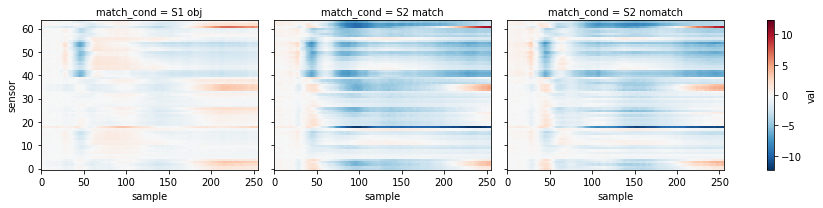

In [42]:
alcoholic = xr.open_mfdataset("no_name/alcoholic/*.nc") 
alcoholic = alcoholic.where(alcoholic.match_cond!='S2 nomatch err', drop=True)
alcoholic = alcoholic.where(alcoholic.match_cond!='S2 match err', drop=True)
alcoholic.groupby('match_cond').mean("trial_num").val.plot(x='sample', y='sensor',  col='match_cond', aspect=1.3, size=3) 


#### Control

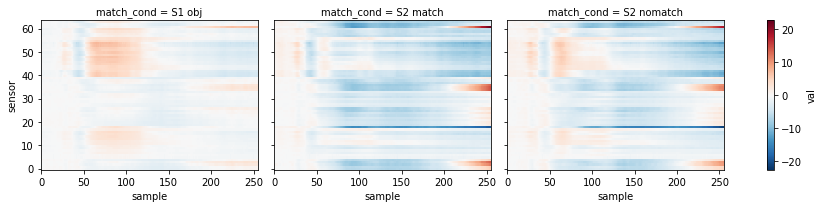

In [43]:
control = xr.open_mfdataset("no_name/control/*.nc")
control = control.where(control.match_cond!='S2 nomatch err', drop=True)
control = control.where(control.match_cond!='S2 match err', drop=True)
control.groupby('match_cond').mean("trial_num").val.plot(x='sample', y='sensor',  col='match_cond', aspect=1.3, size=3) 


# This was not exactly what I was expecting...

The graph for the overall mean for the Alcoholic and the Control sets are different from the two images published on the website refering to the two sets. 

Let's repeat the mean this time keeping the datasets for each subject separate and computing the mean on each and then the mean of the means (for each match condition)

### Assign a new coordinate with the name of the subject

In [6]:
if not os.path.exists('new'): os.mkdir('new')    
for dat in datasets:
    if not os.path.exists('new/'+dat['name']): 
        os.mkdir('new/'+dat['name'])
        for subj in dat['subjs'].keys():
            src = os.path.join(dat['name'], subj + '.nc')
            ds = xr.open_dataset(src)
            ds = ds.assign_coords(name=subj)
            ds = ds.expand_dims('name')
            ds = ds.sortby(['trial_num', 'sample'])
            # delete the error match table
            ds = ds.where(ds.match_cond!='S2 match err', drop=True)
            # save it to another dir just for now
            dst = os.path.join('new/'+dat['name'], subj + '.nc') 
            ds.to_netcdf(dst)

### Visually check the mean with a couple of datasets for each set

In [88]:
ch = xr.open_mfdataset(["new/alcoholic/co2a0000364.nc", "new/alcoholic/co2a0000365.nc", "new/control/co2c0000337.nc", "new/control/co2c0000338.nc"])
ch

<xarray.Dataset>
Dimensions:     (match_cond: 3, name: 4, sample: 256, sensor: 64, trial_num: 363)
Coordinates:
  * name        (name) object 'co2a0000364' 'co2a0000365' ... 'co2c0000338'
  * match_cond  (match_cond) object 'S1 obj' 'S2 match' 'S2 nomatch'
  * sensor      (sensor) int64 0 1 2 3 4 5 6 7 8 ... 55 56 57 58 59 60 61 62 63
  * sample      (sample) int64 0 1 2 3 4 5 6 7 ... 249 250 251 252 253 254 255
    sensor_     (sensor) object 'AF1' 'AF2' 'AF7' 'AF8' ... 'TP8' 'X' 'Y' 'nd'
  * trial_num   (trial_num) int64 0 2 7 9 10 11 12 ... 114 115 116 117 118 119
Data variables:
    val         (name, match_cond, trial_num, sensor, sample) float64 dask.array<shape=(4, 3, 363, 64, 256), chunksize=(4, 3, 88, 64, 256)>

#### Compute the mean for each subject

__First method__

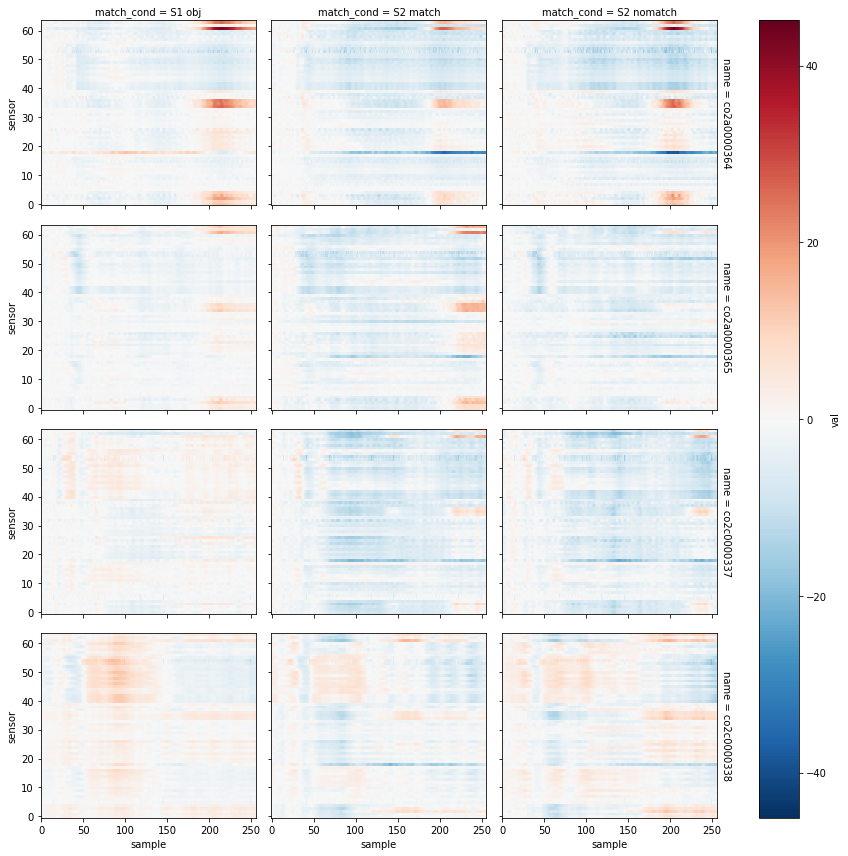

In [89]:
ch.mean("trial_num").val.plot(x='sample', y='sensor', col='match_cond', row='name', aspect=1.3, size=3) 

__Second method__

it looks different just because the scaling of the colors is different

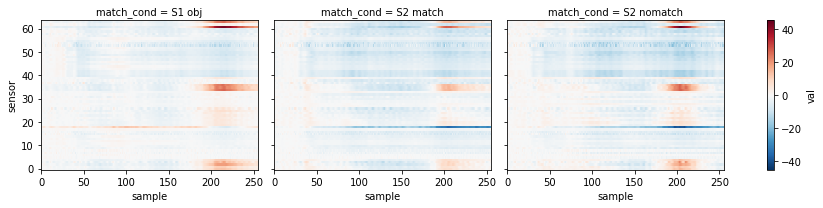

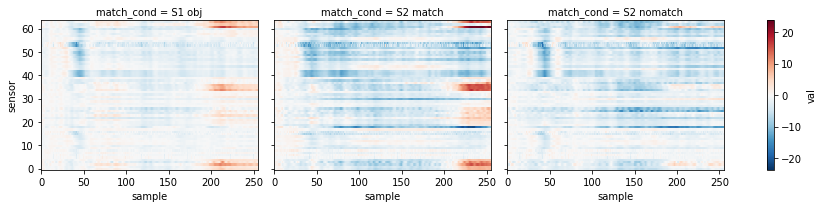

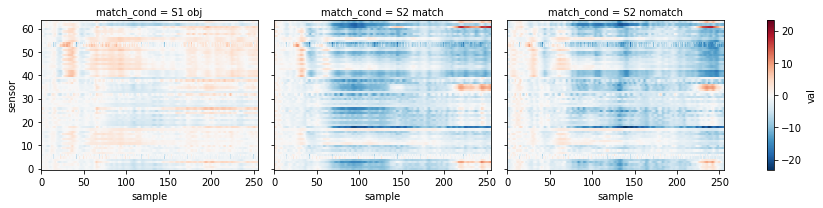

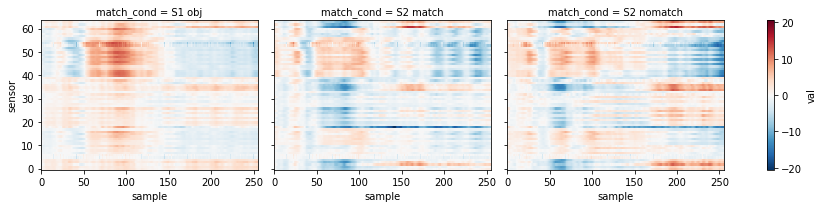

In [105]:
a = xr.open_mfdataset(["new/alcoholic/co2a0000364.nc", "new/alcoholic/co2a0000365.nc"])
c = xr.open_mfdataset(["new/control/co2c0000337.nc", "new/control/co2c0000338.nc"])
mean_a = []
mean_c = []
for name, group in a.groupby('name'):
#     print(name)
    mean = group.groupby('match_cond').mean("trial_num")
    mean.val.plot(x='sample', y='sensor',  col='match_cond', aspect=1.3, size=3) 
    mean_a.append(mean)
for name, group in c.groupby('name'):
#     print(name)
    mean = group.groupby('match_cond').mean("trial_num")
    mean.val.plot(x='sample', y='sensor',  col='match_cond', aspect=1.3, size=3) 
    mean_c.append(mean)


In [109]:
for m in mean_a:
    print(m)
# xr.concat(mean_a, dim='name').mean()    

<xarray.Dataset>
Dimensions:     (match_cond: 3, sample: 256, sensor: 64)
Coordinates:
    name        <U11 'co2a0000364'
  * sensor      (sensor) int64 0 1 2 3 4 5 6 7 8 ... 55 56 57 58 59 60 61 62 63
  * sample      (sample) int64 0 1 2 3 4 5 6 7 ... 249 250 251 252 253 254 255
    sensor_     (sensor) object 'AF1' 'AF2' 'AF7' 'AF8' ... 'TP8' 'X' 'Y' 'nd'
  * match_cond  (match_cond) object 'S1 obj' 'S2 match' 'S2 nomatch'
Data variables:
    val         (match_cond, sensor, sample) float64 dask.array<shape=(3, 64, 256), chunksize=(1, 64, 256)>
<xarray.Dataset>
Dimensions:     (match_cond: 3, sample: 256, sensor: 64)
Coordinates:
    name        <U11 'co2a0000365'
  * sensor      (sensor) int64 0 1 2 3 4 5 6 7 8 ... 55 56 57 58 59 60 61 62 63
  * sample      (sample) int64 0 1 2 3 4 5 6 7 ... 249 250 251 252 253 254 255
    sensor_     (sensor) object 'AF1' 'AF2' 'AF7' 'AF8' ... 'TP8' 'X' 'Y' 'nd'
  * match_cond  (match_cond) object 'S1 obj' 'S2 match' 'S2 nomatch'
Data variables:
  

#### concat and compute the mean along the name dimension

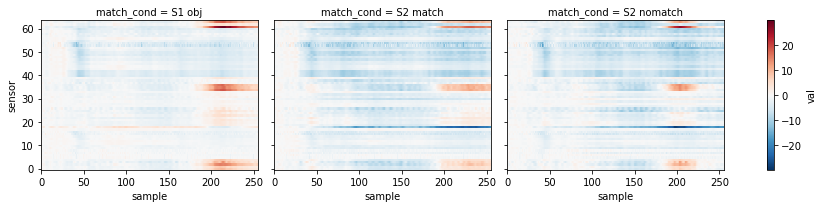

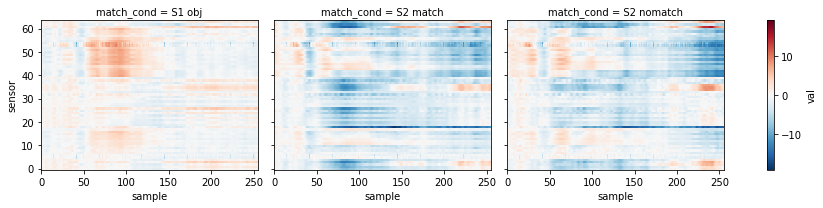

In [115]:
xr.concat(mean_a, dim='name').mean('name').val.plot(x='sample', y='sensor',  col='match_cond', aspect=1.3, size=3) 
xr.concat(mean_c, dim='name').mean('name').val.plot(x='sample', y='sensor',  col='match_cond', aspect=1.3, size=3) 

### These results looks consistent with the average of the two set! Good, let's repeat for the _entire_ datasets for the two sets

#### When compute is run it goes out off memory.... ! 

In [1]:
def _OUT_OF_MEMORY_():
    a = xr.open_mfdataset("new/alcoholic/*.nc")
    mean_a = []
    for name, group in a.groupby('name'):
        mean = group.groupby('match_cond').mean("trial_num")
        mean_a.append(mean.compute()) # <-- OUT OF MEMORY
    # xr.concat(mean_a, dim='name').mean('name').val.plot(x='sample', y='sensor',  col='match_cond', aspect=1.3, size=3) 

#### Let's compute the mean and save it as netCDF file as an intermediate step

In [9]:
def save_mean():
    for dat in datasets:
        if not os.path.exists(os.path.join('mean', dat['name'])):
            os.mkdir(os.path.join('mean', dat['name']))
        for subj, subj_ in dat['subjs'].items():
            src = os.path.join('new', dat['name'], subj + '.nc')
            ds = xr.open_dataset(src)
            mean = ds.groupby('match_cond').mean("trial_num")
            fname = os.path.join('mean',dat['name'], subj + '.nc')
            mean.to_netcdf(fname)
if not os.path.exists('mean'):
    os.mkdir('mean')
    save_mean()

#### Alcoholic

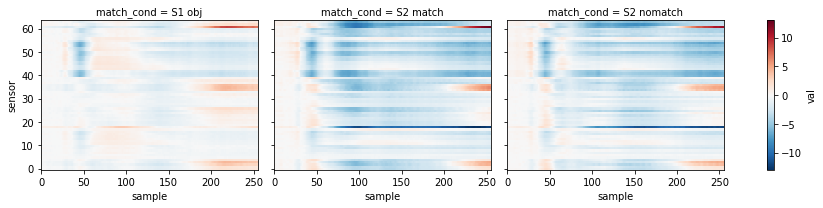

In [28]:
a = xr.open_mfdataset("mean/alcoholic/*.nc")
a = a.where(a.match_cond!='S2 nomatch err', drop=True)
a.groupby('match_cond').mean("name").val.plot(x='sample', y='sensor',  col='match_cond', aspect=1.3, size=3) 


#### Control

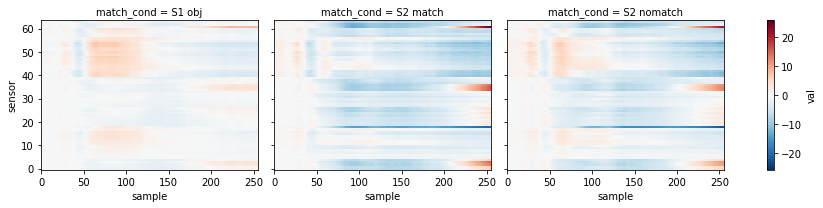

In [29]:
c = xr.open_mfdataset("mean/control/*.nc")
c = c.where(c.match_cond!='S2 nomatch err', drop=True)
c.groupby('match_cond').mean("name").val.plot(x='sample', y='sensor',  col='match_cond', aspect=1.3, size=3) 


### Results looks the same as before as expected. We can conclude that xarray did align correctly even without an explicit dimension for each subject.
Also to notice how close the Alcoholic and Control group looks like once averaged for all the subjects... I wonder if these data are really telling something